# Interaction Prediction

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 5A-D
* Supplemental Figure 6A-H

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

For implementation of the interaction prediction algorithms, see `ExampleUsage/IP_InteractionPrediction.README.md`


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neteval.network_statistics import NetworkStats, load_network_names
from tqdm import tqdm
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import itertools
from goatools.semantic import semantic_similarity
from collections import defaultdict
from neteval.gsea_functions import *
import obonet as obo
from goatools.obo_parser import GODag
from neteval.data_import_export_tools import *

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25


In [3]:
gitdir = os.path.expanduser('~/Git/Network_Evaluation_Tools/')
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))

## Example Analysis

See `Network_Evaluation_Tools/ExampleUsage/InteractionPrediction.README.md` for usage of prediction functionalities.  


## Figures 5A-C - Interaction Prediction Precision

Load the prediction results from Supplemental Table 4

In [4]:
pred_results = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/TableS4.txt'), sep='\t')

In [5]:
pred_results.head()

,Interactome,Fold,Prediction Method,Test Set,P@k
0,APID,1.0,L3,Held-out,0.052175
1,APID,2.0,L3,Held-out,0.051678
2,APID,3.0,L3,Held-out,0.053988
3,APID,4.0,L3,Held-out,0.055043
4,APID,5.0,L3,Held-out,0.055839


In [6]:
import warnings

def compare_prediction_methods(pred_results, test_set, palette, net_order=None, ax=None, top_n=None, exclude_nets=[] ):
    plot_df = pred_results[pred_results['Test Set']==test_set]
    # keep only interactome with results for both prediction methods
    method_counts = plot_df.groupby('Interactome')['Prediction Method'].nunique()
    exclude_nets += method_counts[method_counts < 2].index.values.tolist()
    plot_df = plot_df[~plot_df.Interactome.isin(exclude_nets)]
    if net_order is None:
        net_order = plot_df.Interactome.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('Interactome')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8))
    
    if top_n is not None:
        plot_df = plot_df[plot_df['Interactome'].isin(net_order[:top_n])]
        net_order=net_order[:top_n]
        
    if test_set == 'Held-out':
        #plot strip plot
        plot_df = plot_df.reset_index(drop=True)
        sns.stripplot(data = plot_df, y='Interactome', x='P@k', ax=ax, hue='Prediction Method', dodge=False, s=3, 
                      order=net_order, jitter=False, edgecolor='black', linewidth=0.25, alpha=0.5,  
                      hue_order=['MPS', 'L3'], palette=palette)
        sns.pointplot(data = plot_df, y='Interactome', x='P@k', ax=ax, hue='Prediction Method', dodge=False,
                      order=net_order, linestyle='none', errorbar=None, marker='|', markersize=6,  
                      hue_order=['MPS', 'L3'], palette=palette)
        # add horizontal lines between y ticks
        for i in range(len(net_order)):
            ax.hlines(i+0.5, 0, 1, color='grey', linewidth=0.25)
        ax.set_ylim(len(net_order)-0.5, -0.5)
        
    else:
        #plot bar plots
        plot_df = plot_df.reset_index(drop=True)
        sns.barplot(data=plot_df, y='Interactome', x='P@k', ax=ax, hue='Prediction Method', order=net_order, 
                    hue_order=['MPS', 'L3'], alpha=1, errorbar=None, edgecolor='black', 
                    linewidth=0.25, palette=palette, saturation=1)
    return net_order
    
    

In [7]:
pred_results

,Interactome,Fold,Prediction Method,Test Set,P@k
0,APID,1.0,L3,Held-out,0.052175
1,APID,2.0,L3,Held-out,0.051678
2,APID,3.0,L3,Held-out,0.053988
3,APID,4.0,L3,Held-out,0.055043
4,APID,5.0,L3,Held-out,0.055839
...,...,...,...,...,...
921,ReactomeFI,NaN,MPS,PANTHER,0.005659
922,SIGNOR,NaN,MPS,PANTHER,0.038402
923,SPIKE,NaN,MPS,PANTHER,0.023593
924,Wan,NaN,MPS,PANTHER,0.000000


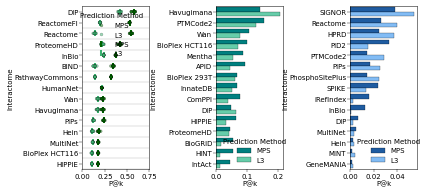

In [8]:

_, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize=(6, 3), gridspec_kw={'wspace': 1})
_ = compare_prediction_methods(pred_results, test_set='Held-out', net_order='P@k', ax=ax1, 
                           palette=['darkgreen', 'mediumseagreen'], top_n=15)
ax1.set_xlim(0, 0.75)

_ = compare_prediction_methods(pred_results, test_set='CORUM', net_order='P@k', ax=ax2, 
                           palette=['teal', 'mediumaquamarine'], top_n=15, 
            exclude_nets=[ 'ReactomeFI','PathwayCommons', 'GeneMANIA', 'ConsensusPathDB', 'iRefIndex'])

_ = compare_prediction_methods(pred_results, test_set='PANTHER', net_order='P@k', ax=ax3, 
                           palette=['#1f5ca1', '#82bcf5'], top_n=15, 
            exclude_nets=[ 'ReactomeFI','PathwayCommons'])

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore deprecation warning
    plt.savefig(os.path.join(figdir, 'Fig5ABC_interaction_prediction_Pk.jpg'))

## Figure 5D - Network Coverage of Predicted Interactions

In [9]:
coverage_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig5D_interaction_coverage_revised.csv'))

In [10]:
coverage_df['weighted_mean'] = coverage_df.apply(lambda x: (x['1'] + (2)*x['2-5'] + 6*x['6-10'] + 11*x['11-20'] + 21*x['21+'])/x['k'], axis=1)

In [11]:
coverage_df

,random_means,random_medians,top_k_mean,top_k_median,k,0,1,2-5,6-10,11-20,21+,network,Name,method,weighted_mean,size
0,0.16,0.0,7.130000,4.0,100,24,6,26,14,27,3,apid.1,APID,MPS,5.02,NaN
1,0.12,0.0,7.130000,4.0,100,24,6,26,14,27,3,apid.1,APID,MPS,5.02,NaN
2,0.12,0.0,7.130000,4.0,100,24,6,26,14,27,3,apid.1,APID,MPS,5.02,NaN
3,0.30,0.0,7.130000,4.0,100,24,6,26,14,27,3,apid.1,APID,MPS,5.02,NaN
4,0.21,0.0,7.130000,4.0,100,24,6,26,14,27,3,apid.1,APID,MPS,5.02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,0.79,0.0,8.019802,5.0,100,15,13,23,26,9,15,youn,Youn,L3,6.29,147166.0
8096,0.95,0.0,8.019802,5.0,100,15,13,23,26,9,15,youn,Youn,L3,6.29,147166.0
8097,0.73,0.0,8.019802,5.0,100,15,13,23,26,9,15,youn,Youn,L3,6.29,147166.0
8098,1.43,0.0,8.019802,5.0,100,15,13,23,26,9,15,youn,Youn,L3,6.29,147166.0


In [12]:
def plot_coverage_stats(coverage_df, ax=None, order=None, **kwargs):
    coverage_stats =coverage_df.drop_duplicates(subset=['network']).set_index('Name')
    stack_data = coverage_stats.groupby(['Name']).mean().loc[:, ('0', '1', '2-5', '6-10', '11-20', '21+', 'weighted_mean')].dropna()
    return_order=False
    if order is None:
        #order=list(stack_data.sort_values(by=['21+', '11-20', '6-10', '2-5', '1'], ascending=False).sort_values('0').index)
        order=list(stack_data.sort_values(by=['weighted_mean'], ascending=False).index)
        return_order=True
    if ax is None:
        _ = plt.figure(figsize=(10, 2))
        ax= plt.gca()
    stack_data.drop(columns='weighted_mean').loc[order].plot(kind='bar', stacked=True, edgecolor='black', ax=ax, 
                            color=['#b8de29', '#73d055', '#29af7f', '#238a8d', '#33638d', 'darkslateblue'][::-1], **kwargs)
    if return_order:
        return order
    else:
        return stack_data


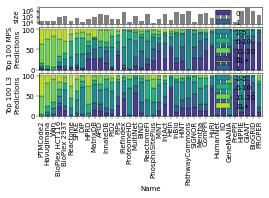

In [13]:
_, [ax3, ax1, ax2] = plt.subplots(nrows=3, ncols=1, figsize=(4, 2), sharex=True, gridspec_kw={'hspace':0.1, 'height_ratios':[0.4, 1, 1]})

order_list = plot_coverage_stats(coverage_df[coverage_df.method=='MPS'], ax=ax1, width=0.8, use_index=True, order=None)
x = plot_coverage_stats(coverage_df[coverage_df.method=='L3'], ax=ax2, order=order_list, width=0.8, use_index=True)
# get x order from ax2
sns.barplot(coverage_df[coverage_df.method=='L3'].groupby('Name')['size'].mean().loc[order_list], ax=ax3, color='grey')
ax1.set_ylabel('Top 100 MPS\nPredictions')
ax2.set_ylabel('Top 100 L3\nPredictions')
ax3.set_yscale('log')

## Supplemental Figures

### SFig 6A-B  - CORUM/PANTHER Overlap


External set sizes:
* **CORUM** = 41034
* **PANTHER** = 24238

In [14]:
overlap_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data', 'FigS6_corum_panther_overlap.txt'), sep='\t', index_col=0)

<AxesSubplot:xlabel='%PANTHER', ylabel='Count'>

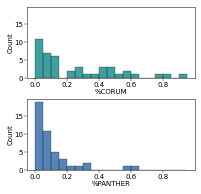

In [15]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(3,3), sharey=True, gridspec_kw={'hspace':0.3})
sns.histplot(overlap_df, x='%CORUM', ax=ax1, bins=[i/100 for i in range(0, 100, 5)], color='teal')
sns.histplot(overlap_df, x='%PANTHER', ax=ax2, bins=[i/100 for i in range(0, 100, 5)], color='#1f5ca1')


### SFig 6C-D - CORUM/PANTHER Overlap vs Performance

In [16]:
# exclude interactomes that directly incorporate the external data sets
exclude_corum = ['ReactomeFI', 'PathwayCommons', 'GeneMANIA', 'ConsensusPathDB', 'iRefIndex']
exclude_panther=['ReactomeFI', 'PathwayCommons']

In [17]:
#plot_df.groupby('Test Set')[['P@k', '%CORUM']].corr()

P@k    %CORUM
Test Set                           
CORUM    P@k     1.000000  0.084231
         %CORUM  0.084231  1.000000
Held-out P@k     1.000000 -0.060976
         %CORUM -0.060976  1.000000
PANTHER  P@k     1.000000 -0.324213
         %CORUM -0.324213  1.000000

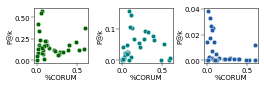

In [18]:
corum_df = pred_results[(pred_results['Prediction Method'] == 'MPS') & (~pred_results.Interactome.isin(exclude_corum))].groupby(['Interactome', 'Test Set'])['P@k'].mean().reset_index()
_, axs = plt.subplots(1, 3, figsize=(4, 1), gridspec_kw={'wspace':0.6})
colors=['#006400', '#008080', '#1f5ca1'] 
plot_df = corum_df.join(overlap_df, on='Interactome')
for i, test_set in enumerate(['Held-out', 'CORUM', 'PANTHER']):
    sns.scatterplot(plot_df[plot_df['Test Set']==test_set], x='%CORUM', y='P@k', ax = axs[i], s=20, color=colors[i])
plot_df.groupby('Test Set')[['P@k', '%CORUM']].corr()                                                                                        

P@k  %PANTHER
Test Set                             
CORUM    P@k       1.000000 -0.266053
         %PANTHER -0.266053  1.000000
Held-out P@k       1.000000 -0.080607
         %PANTHER -0.080607  1.000000
PANTHER  P@k       1.000000 -0.009243
         %PANTHER -0.009243  1.000000

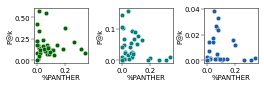

In [19]:
panther_df = pred_results[(pred_results['Prediction Method'] == 'MPS') & (~pred_results.Interactome.isin(exclude_panther))].groupby(['Interactome', 'Test Set'])['P@k'].mean().reset_index()
_, axs = plt.subplots(1, 3, figsize=(4, 1), gridspec_kw={'wspace':0.6})
colors=['#006400', '#008080', '#1f5ca1'] 
for i, test_set in enumerate(['Held-out', 'CORUM', 'PANTHER']):
    plot_df = panther_df.join(overlap_df, on='Interactome')
    sns.scatterplot(plot_df[plot_df['Test Set']==test_set], x='%PANTHER', y='P@k', ax = axs[i], s=20, color=colors[i])
plot_df.groupby('Test Set')[['P@k', '%PANTHER']].corr()

### SFig 6E - Hierarchical communities

For implementation of HiDeF, see `Supplemental_Code/HiDeF_README.md`

In [20]:
complex_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS6EFGH_complex_prediciton.csv'), index_col=0)

In [21]:
def plot_stacked_bar(df, bin_edges,order=None, ax=None):
    """
    Plots a stacked bar graph showing the distribution of cluster sizes per network.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Network' and 'Cluster_size' columns.
    bin_edges (list): List of bin edges for binning the 'Cluster_size'.
    """
    
    # Create a column 'Bin' that assigns each row to a bin based on 'Cluster_size'
    df['Bin'] = pd.cut(df['Cluster_size'], bins=bin_edges, include_lowest=True)
    col_order = df.sort_values(by='Bin').Bin.unique()
    # Count the number of instances per network and per bin
    bin_counts = df.groupby(['Network', 'Bin']).size().unstack(fill_value=0)
    bin_counts = bin_counts.loc[:, col_order]
    # Plotting the stacked bar chart
    if order is not None:
        bin_counts.loc[order].plot(kind='bar', stacked=True, colormap='Blues_r', ax=ax)
        df.Network.value_counts().loc[order].plot(kind='bar', ax=ax, edgecolor='black', fill=None)
    else:
        bin_counts.plot(kind='bar', stacked=True, colormap='Blues_r', ax=ax)
        df.Network.value_counts().plot(kind='bar', ax=ax, edgecolor='black', fill=None)
    
    # Adding labels and title
    plt.xlabel('Network')
    plt.ylabel('Count')
    plt.title('Distribution of Cluster Sizes per Network')
    
    # Display the plot
    plt.legend(title='Size Bins')

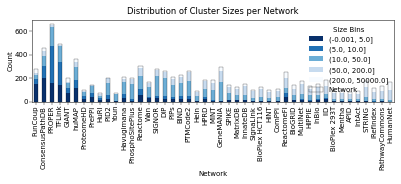

In [22]:
_ = plt.figure(figsize=(6.5, 1.5))
order = complex_df.groupby('Network').Cluster_size.median().sort_values().index.tolist()
plot_stacked_bar(complex_df, [0, 5,10, 50, 200, 50000, 100000], ax=plt.gca(), order=order)
plt.savefig(os.path.join(figdir, 'FigS6E_complex_pred_sizes.jpg'), dpi=400, bbox_inches='tight')

### SFig 6F-H - Assessment of hierarchical communities

For implementation of HiDeF, see `Supplemental_Code/HiDeF_README.md`
#### Example Analysis

Here we examine the precomputed hierarchy for DIP. Note that the HiDeF algorithm is not deterministic so slight variation is expected between repeated runs.

In [23]:
dip_communities = pd.read_csv(os.path.join(gitdir, 'Data/example_outputs/ComplexPrediction', 'dip.10.nodes'), sep='\t', header=None,
                             names=['ClusterID', 'Size', 'Genes', 'Persistence' ])

Community Sizes

Text(0, 0.5, 'Community count')

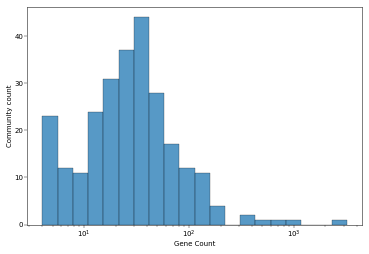

In [24]:
sns.histplot(dip_communities['Size'], bins=20, log_scale=True)
plt.xlabel('Gene Count')
plt.ylabel('Community count')

CORUM overlap

In [25]:
def load_corum_data(corum_file, outdir):
    corum_df = pd.read_csv(corum_file, sep='\t', usecols=['ComplexID', 'ComplexName', 'subunits(Entrez IDs)', 'GO ID', 'GO description'])
    corum_df['NumSubunits'] = corum_df['subunits(Entrez IDs)'].apply(lambda x: len(x.split(';')))
    complex_info = corum_df.loc[:,['ComplexID', 'ComplexName', 'GO ID', 'GO description', 'NumSubunits']]
    complex_info.to_csv(os.path.join(outdir,'corum_complex_info.tsv'), sep='\t')
    all_complexes = []
    for index, row in corum_df.iterrows():
        subunits = row['subunits(Entrez IDs)'].split(';')
        subunits = [int(x) for x in subunits if x.isnumeric()]
        all_complexes.append(pd.DataFrame({'Complex': row['ComplexID'], 'Subunit': subunits}))
    complex_df = pd.concat(all_complexes).reset_index(drop=True)
    complex_df.Subunit = complex_df.Subunit.astype(int)
    complex_df['value'] = 1
    complex_mat = complex_df.pivot_table(index='Subunit', columns='Complex', values='value')
    complex_mat = complex_mat.fillna(0)
    complex_mat.index.name=None
    complex_mat.columns.name=None
    complex_mat.to_csv(os.path.join(outdir, 'corum_processed.tsv'), sep='\t')
    return complex_mat

def process_network_clusters(prefix, outdir):
    test_df = pd.read_csv(os.path.join(outdir, f'{prefix}.nodes'), usecols=[0,2], sep='\t', header=None, names=['ID', 'Genes'])
    all_clusters = []
    for index, row in test_df.iterrows():
        subunits = row['Genes'].split(' ')
        subunits = [int(x) for x in subunits if x.isnumeric()]
        all_clusters.append(pd.DataFrame({'Complex': row['ID'], 'Subunit': subunits}))
    test_df = pd.concat(all_clusters).reset_index(drop=True)
    test_df.Subunit = test_df.Subunit.astype(int)
    test_df['value'] = 1
    test_mat = test_df.pivot_table(index='Subunit', columns='Complex', values='value')
    test_mat = test_mat.fillna(0)
    test_mat.index.name=None
    test_mat.columns.name=None
    return test_mat
    
def standardize_mats(test_mat, complex_mat):
    not_in_test = [x for x in complex_mat.index if x not in test_mat.index]
    not_in_corum = [x for x in test_mat.index if x not in complex_mat.index]
    complex_filled = pd.concat([complex_mat, pd.DataFrame({comp: 0 for comp in complex_mat.columns}, index=not_in_corum)])
    test_filled = pd.concat([test_mat, pd.DataFrame({comp: 0 for comp in test_mat.columns}, index=not_in_test)])
    complex_filled.sort_index(inplace=True)
    test_filled.sort_index(inplace=True)
    return complex_filled, test_filled

def calculate_Jaccard(test_filled, complex_filled):
    intersection = np.dot(test_filled.T, complex_filled)
    sum1 = np.repeat([np.sum(test_filled, axis=0).values], [complex_filled.shape[1]], axis=0).T
    sum2 = np.repeat([np.sum(complex_filled, axis=0).values], [test_filled.shape[1]], axis=0)
    union = sum1 + sum2 - intersection
    J = intersection / union
    return J

def get_best_matches(J, test_ids, complex_ids):
    best_match_to_test = {test_ids[i]: complex_ids[x]for i, x in enumerate(np.argmax(J, axis=1))}
    best_similarity_test = {test_ids[i]: x for i, x in enumerate(np.max(J, axis=1))}

    # Find the best match for each complex in dfB against dfA
    best_match_to_complex = {complex_ids[i]: test_ids[x] for i, x in enumerate(np.argmax(J, axis=0))}
    best_similarity_complex = {complex_ids[i]: x for i, x in enumerate(np.max(J, axis=0))}
    test_results = pd.DataFrame({'CORUM_match':best_match_to_test, 'J': best_similarity_test})
    complex_results = pd.DataFrame({'Test_match': best_match_to_complex, 'J': best_similarity_complex})
    return test_results, complex_results

def map_complex_ids(res_df, outdir ):
    complex_info = pd.read_csv(os.path.join(outdir,'corum_complex_info.tsv'), sep='\t', index_col=0)
    if 'CORUM_match' in res_df.columns:
        res_df['TestID'] = res_df.index
        res_df = res_df.merge(complex_info.loc[:, ('ComplexID', 'ComplexName', 'NumSubunits')], left_on='CORUM_match', right_on='ComplexID', how='left')
    else:
        res_df = res_df.merge(complex_info.loc[:, ('ComplexID', 'ComplexName', 'NumSubunits')], left_index=True, right_on='ComplexID', how='left')
    return res_df

def write_results(test_df, complex_df, prefix, outdir):
    test_df.to_csv(os.path.join(outdir, prefix+ '.test_to_corum.tsv'), sep='\t')
    complex_df.to_csv(os.path.join(outdir, prefix+ '.corum_to_test.tsv'), sep='\t')
    
def corum_analysis_wrapper(corum_file, prefix, outdir):
    # load the necessary data
    complex_mat = load_corum_data(corum_file, outdir=outdir)
    test_mat = process_network_clusters(prefix, outdir)
    # calculate all Jaccard indexes
    complex_filled, test_filled = standardize_mats(test_mat, complex_mat)
    J = calculate_Jaccard(test_filled, complex_filled)
    # identify and get information on best matches
    test_res, complex_res = get_best_matches(J, test_filled.columns, complex_filled.columns)
    complex_out = map_complex_ids(complex_res, outdir)
    test_out = map_complex_ids(test_res, outdir)
    #save the results
    write_results(test_out, complex_out, prefix, outdir)

In [26]:
corum_file = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS6F_corum_complexes.txt')

In [27]:
# Perform the analysis
corum_analysis_wrapper(corum_file, 'dip.10', os.path.join(gitdir, 'Data/example_outputs/ComplexPrediction'))

In [30]:
# Load the results
pref='dip'
corum_to_test = pd.read_csv(os.path.join(gitdir, f'Data/example_outputs/ComplexPrediction/{pref}.10.corum_to_test.tsv'), sep='\t', index_col=0)

In [31]:
# Identify CORUM complexes with at least one community with J >= 0.5
corum_to_test[corum_to_test.J >= 0.5].shape

(43, 5)

Calculate GO Homogeneity for clusters with < 20 genes

In [32]:
def load_go_data():
    data = pd.read_csv('gene2go', sep='\t', names=['TaxID', 'GeneID', 'GO_term', 'Evidence', 'Qualifier', 'GO_name', 'Pubmed', 'Category'])
    geneid2go = data.groupby('GeneID')['GO_term'].apply(set).to_dict()
    godag = GODag('go.obo')
    branches = {'BP': data[data.Category=='Process'].GO_term.unique(), 'MF': data[data.Category=='Function'].GO_term.unique(), 'CC': data[data.Category=='Component'].GO_term.unique()}
    return geneid2go, godag, branches

def calculate_go_similarity(go_terms1, go_terms2, go_dag, already_calculated={}):
    """
    Calculate the semantic similarity between two sets of GO terms using Wang et al.'s method.

    Parameters:
    go_terms1 (list): List of GO terms for the first protein.
    go_terms2 (list): List of GO terms for the second protein.
    go_dag (GODag): The GO DAG loaded from an OBO file.
    method (str): The method used for semantic similarity ('Wang' is the default).

    Returns:
    float: The average semantic similarity score between the two sets of GO terms.
    """
    scores = []
    for term1 in go_terms1:
        for term2 in go_terms2:
            if (term1, term2) in already_calculated:
                score = already_calculated[(term1, term2)]
            elif (term2, term1) in already_calculated:
                score = already_calculated[(term2, term1)]
            else:
                score = semantic_similarity(term1, term2, go_dag)
                scores.append(score)
                already_calculated[(term1, term2)] = score
    #scores = [score for score in scores if score is not None]
    return sum(scores) / len(scores) if scores else 0.0, already_calculated

def calculate_homogeneity(clusters, go_annotations, go_dag, go_branches):
    """
    Calculate the homogeneity of each cluster based on GO semantic similarity.

    Parameters:
    clusters (dict): A dictionary with cluster IDs as keys and lists of proteins (nodes) as values.
    go_annotations (pd.DataFrame): DataFrame with columns ['Protein', 'GO_term', 'Category']

    Returns:
    dict: A dictionary with cluster IDs as keys and homogeneity scores as values.
    """
    homogeneity_dict = {}
    already_calculated_go = defaultdict(float)
    already_calculated_genes = defaultdict(dict)
    
    for cluster_id, genes in tqdm(clusters.items()):
        genes = [g for g in genes if g in go_annotations]
        gene_pairs = list(itertools.combinations(genes, 2))
        scores = {'mf' : [], 'bp': [],'cc': []}
        
        for gene1, gene2 in gene_pairs:
            if (gene1, gene2) in already_calculated_genes:
                for branch in ['mf', 'bp', 'cc']:
                    scores[branch].append(already_calculated_genes[(gene1, gene2)][branch])
                continue
            elif (gene2, gene1) in already_calculated_genes:
                for branch in ['mf', 'bp', 'cc']:
                    scores[branch].append(already_calculated_genes[(gene2, gene1)][branch])
                continue
            terms1 = {'go' :go_annotations[gene1]}
            terms2 = {'go' :go_annotations[gene2]}
            branch_names = {'mf':'molecular_function', 'bp':'biological_process', 'cc':'cellular_component'}
            for branch in ['mf', 'bp', 'cc']:
                terms1[branch] = [t for t in terms1['go'] if t in go_dag and (go_dag[t].namespace == branch_names[branch])]
                terms2[branch] = [t for t in terms2['go'] if t in go_dag and (go_dag[t].namespace == branch_names[branch])]
      
            already_calculated_genes[(gene1, gene2)] = {'mf':0, 'bp':0, 'cc':0}
            for branch in ['mf', 'bp', 'cc']:
                if terms1[branch] and terms2[branch]:
                    score, already_calculated_go = calculate_go_similarity(terms1[branch], terms2[branch], 
                                                                           go_dag, already_calculated_go)
                    scores[branch].append(score)
                    already_calculated_genes[(gene1, gene2)][branch] = score

        avg_scores = {}
        for branch in ['mf', 'bp', 'cc']:
            avg_scores[branch] = sum(scores[branch]) / len(scores[branch]) if scores[branch] else 0.0
        
        # Calculate the final GO score for the cluster
        go_score = (avg_scores['mf'] + avg_scores['bp'] + avg_scores['cc']) / 3
        homogeneity_dict[cluster_id] = go_score
    
    return homogeneity_dict

In [33]:
gd, godag, go_branches = load_go_data()

/tmp/ipykernel_960287/1491414914.py:1: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  gd, godag, go_branches = load_go_data()


go.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms


In [34]:
all_comms = dip_communities.set_index('ClusterID').Genes.to_dict()
all_comms = {k: [int(x) for x in v.split(' ') if x.isnumeric()] for k, v in all_comms.items()}

In [35]:

sub_comms = {k: v for k, v in all_comms.items() if len(v) < 20}
homogs = calculate_homogeneity(sub_comms, gd, godag, go_branches)

100%|██████████| 93/93 [00:27<00:00,  3.35it/s]


Text(0, 0.5, 'Community count')

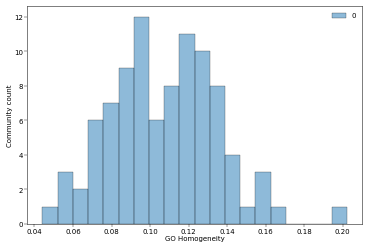

In [36]:
sns.histplot(homogs.values(), bins=20)
plt.xlabel('GO Homogeneity')
plt.ylabel('Community count')

Clustering Coefficient

In [37]:
def calculate_clustering_coefficient(G, clusters):
    """
    Calculate the average clustering coefficient of each cluster in the graph G.

    Parameters:
    G (networkx.Graph): The graph representing the protein interactions.
    clusters (dict): A dictionary with cluster IDs as keys and lists of proteins (nodes) as values.

    Returns:
    dict: A dictionary with cluster IDs as keys and clustering coefficient scores as values.
    """
    clustering_coefficient_dict = {}
    for cluster_id, nodes in clusters.items():
        if len(nodes) < len(G.nodes):
            subgraph = G.subgraph(nodes)
            clustering_coefficient = nx.average_clustering(subgraph)
            clustering_coefficient_dict[cluster_id] = clustering_coefficient
    return clustering_coefficient_dict

In [38]:
G = load_edgelist_to_networkx(os.path.join(gitdir, 'Data/example_outputs','dip_net.txt'), id_type="Entrez", testmode=False, timer=None, delimiter="\t", node_cols=[0,1],keep_attributes=False, verbose=False)

In [39]:
coeffs = calculate_clustering_coefficient(G, all_comms)

Text(0, 0.5, 'Community count')

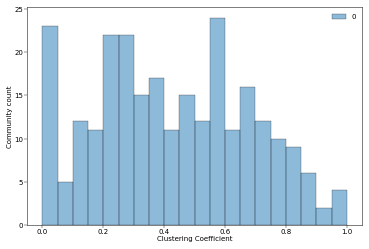

In [40]:
sns.histplot(coeffs.values(), bins=20)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Community count')

#### Full Figure

In [47]:
network_classes = load_network_names(os.path.join(gitdir, "StateOfTheInteractomes_Notebooks/Data/network_classifications.txt"))
network_classes  = {**network_classes, **{ network_names[k]:v for k, v in network_classes.items()}}

Assess evaluation metrics for complexes with < 200 genes

In [42]:
complex_df['Class'] = complex_df.Network.map(network_classes)
complex_df_small = complex_df[complex_df.Cluster_size < 200]

In [43]:
corum_ranks = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig6F_corum_complex_results.csv'), index_col=0)
corum_ranks['CORUMRank'] = corum_ranks['#CORUM Recovered'].rank(ascending=False)
corum_ranks['Network'] = corum_ranks.index

In [44]:
go_ranks = pd.DataFrame({'go_score': complex_df_small.groupby('Network').Homogeneity.mean().sort_values(ascending=False)})
go_ranks.index.name = None
go_ranks['GORank'] = go_ranks['go_score'].rank(ascending=False)
top_go = [x for x in go_ranks[0:15].index.values]

In [45]:
coeff_ranks = pd.DataFrame({'coeff': complex_df_small.groupby('Network').ClusteringCoeff.mean().sort_values(ascending=False)})
coeff_ranks.index.name = None
coeff_ranks['CoeffRank'] = coeff_ranks['coeff'].rank(ascending=False)
top_coeff = [x for x in coeff_ranks[0:15].index.values]

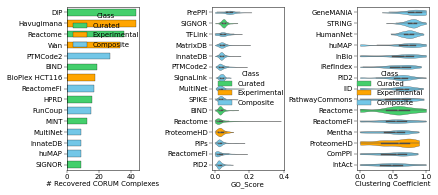

In [46]:
corum_ranks['Class'] = corum_ranks.index.map(network_classes)
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 3), gridspec_kw={'wspace':1})
sns.barplot(corum_ranks.iloc[0:15], x='#CORUM Recovered',y='Network', ax=ax1, hue='Class', saturation=1,
           palette=['#44cf6c', '#ffa500', '#73c7e7'], hue_order=['Curated', 'Experimental', 'Composite'],
           edgecolor='black', width=0.6)
sns.violinplot(complex_df_small[complex_df_small.Network.isin(top_go)], x='Homogeneity', y='Network', hue='Class', 
               palette=['#44cf6c', '#ffa500', '#73c7e7'], hue_order=['Curated', 'Experimental', 'Composite'], 
               saturation=1, ax=ax2, cut=0, order=top_go)
sns.violinplot(complex_df_small[complex_df_small.Network.isin(top_coeff)], x='ClusteringCoeff', y='Network', hue='Class', 
               palette=['#44cf6c', '#ffa500', '#73c7e7'], hue_order=['Curated', 'Experimental', 'Composite'],
               saturation=1, ax=ax3, cut=0, order=top_coeff)
ax1.set_xlabel("# Recovered CORUM Complexes")
ax2.set_xlabel("GO_Score")
ax3.set_xlabel("Clustering Coefficient")
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('')
plt.savefig(os.path.join(figdir, 'FigS6FGH_complex_pred_stats.jpg'), dpi=400, bbox_inches='tight')